In [2]:
import sys
import pandas as pd
sys.path.append("..")

%load_ext autoreload
%autoreload 2

# Exploratory Data Analysis


## Cohort ROI - Mathematical Formulation

We define a **cohort** $c$, created at time $t=0$. For each loan $i \in c$:

- $L_i $: principal loan amount granted.  
- $R_i(t) $: cumulative repayments (including normal repayments and collections) up to time $t$.  
- $L_i$ : amount of loan $i$.

The **net cash flow** $F_i$ of loan $i$ up to time $t$ is:

$$
F_i(t) = R_i(t) - L_i
$$

The **net cash flow of cohort $c$** up to time $t$ is:

$$
F_c(t) = \sum_{i \in c} F_i(t) = \sum_{i \in c} \big(R_i(t) - L_i\big)
$$

The **Return on Investment (ROI)** for cohort $c$ up to time $t$ is defined as:

$$
ROI_c(t) = \frac{F_c(t)}{\sum_{i \in c} L_i}
$$

or equivalently:

$$
ROI_c(t) = \frac{\sum_{i \in c} R_i(t)}{\sum_{i \in c} L_i} - 1
$$

### Properties

- At the start ($t=0$), repayments are zero, so $ROI_c(0) = -1$.  
- As repayments occur, $ROI_c(t)$ increases.  
- If $ROI_c(H) > 0$, the cohort has become profitable at horizon $H$.  

## Computing ROI curves

The initial step involves creating a consolidated table that combines repayment data, loan details, and batch identifiers. This comprehensive table will enable us to group repayments by batch and subsequently calculate the Return on Investment (ROI) curves for each cohort.

In [3]:
from src.data_manipulation import load_data

# Load and prepare all data
allowlist, loans, repayments, loans_and_cohort, repayments_and_loans = load_data(
    "../database.db", remove_loans_with_errors=True
)

In [4]:
# Dataframe of loans with cohort information
display(loans_and_cohort.head())

,loan_id,user_id,created_at,updated_at,annual_interest,loan_amount,status,batch,allowlisted_date,batch_letter,cohort_start,created_at_h_days,updated_at_h_days
0,561fb48b1bcc88cdb406cb4e31aedc10735ab76b57ca8e...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-06,2023-12-06 20:50:26.060,3.2,500.0,executed,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05,D,2023-12-05,1,1
1,561fb48b1bcc88cdb406cb4e31aedc10735ab76b57ca8e...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-06,2023-12-06 20:50:26.049,3.2,500.0,executed,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05,D,2023-12-05,1,1
2,561fb48b1bcc88cdb406cb4e31aedc10735ab76b57ca8e...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-06,2023-12-22 07:25:57.889,3.2,500.0,repaid,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05,D,2023-12-05,1,17
3,561fb48b1bcc88cdb406cb4e31aedc10735ab76b57ca8e...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-06,2023-12-06 20:54:10.858,3.2,500.0,executed,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05,D,2023-12-05,1,1
4,03bd8fb1f4c0504c2c97da9a059fcf4df1f5b60caef436...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-22,2023-12-22 13:41:48.169,3.2,500.0,executed,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05,D,2023-12-05,17,17


In [5]:
display(loans_and_cohort.status.value_counts())

status
executed           107281
repaid              40467
debt_collection      8497
debt_repaid          4048
Name: count, dtype: int64

In addition to default repayment columns, the ``load_data`` function created other three important columns:
- **cohort_start:** the date when the user was allowlisted
- **h_days:** the number of days since the cohort_start until the repayment date
- **repayment_total:** the total amount repaid by the user, including both normal repayments and collections.

In [6]:
# Dataframe of repayments with loans and cohort information, 
# we also have historical status of each loan
display(repayments_and_loans.head())

,date,loan_id,repayment_amount,billings_amount,batch_letter,allowlisted_date,loan_amount,cohort_start,created_at,created_at_h_days,h_days,repayment_total
0,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,B,2022-08-29,9750.0,2022-08-29,2022-08-30,1.0,106.0,0.15
1,2022-12-13,059f1d15ef6b5990280bb37efb4325b71b1d3b68c9c847...,0.0,71.88,B,2022-08-29,2750.0,2022-08-29,2022-08-30,1.0,106.0,71.88
2,2022-12-13,bfde49d91ce96adc8b2f04a25850c929f6688d81e26b06...,0.0,1312.95,B,2022-08-29,9750.0,2022-08-29,2022-08-30,1.0,106.0,1312.95
3,2022-12-13,c1636359078ef9fc7a37aacb4afba4610d2492c1769d24...,0.0,344.18,B,2022-08-29,4000.0,2022-08-29,2022-08-30,1.0,106.0,344.18
4,2022-12-13,6cc14f085ec7834225629bc7e619d1d1bc03b36b1f5349...,0.0,98.07,B,2022-08-29,3250.0,2022-08-29,2022-08-30,1.0,106.0,98.07


Now, we need to compute the loan amount per batch.

In [7]:
from src.data_manipulation import compute_cohort_principal

cohort_principal = compute_cohort_principal(loans_and_cohort)
display(cohort_principal)

batch_letter
A      786541.62
B    22242140.15
C    30258238.56
D     2583135.26
E    13937768.80
F     8291253.51
G     3644997.60
Name: cohort_principal, dtype: float64

Now, let's group the loans by batch and days since cohort start, summing the repayments. Then, we will compute the cumulative sum of repayments over time for each batch. Finally, we will merge the cumulative repayments with the principal amounts to calculate the ROI for each cohort over time.

In [8]:
from src.data_manipulation import compute_roi_curves

roi_curves_df = compute_roi_curves(repayments_and_loans, cohort_principal)

In [9]:
display(roi_curves_df.head(10))

,batch_letter,h_days,repayment_total,cohort_principal,ROI
0,A,0.0,200.880000,786541.62,-0.999745
1,A,1.0,812.270000,786541.62,-0.998967
2,A,2.0,2685.620000,786541.62,-0.996586
3,A,3.0,2916.920000,786541.62,-0.996291
4,A,4.0,5725.787277,786541.62,-0.992720
5,A,5.0,8275.687966,786541.62,-0.989478
6,A,6.0,9802.077703,786541.62,-0.987538
7,A,7.0,10489.405727,786541.62,-0.986664
8,A,8.0,12559.529520,786541.62,-0.984032
9,A,9.0,14277.950965,786541.62,-0.981847


Now, we can iterate over each batch to plot the ROI curves.

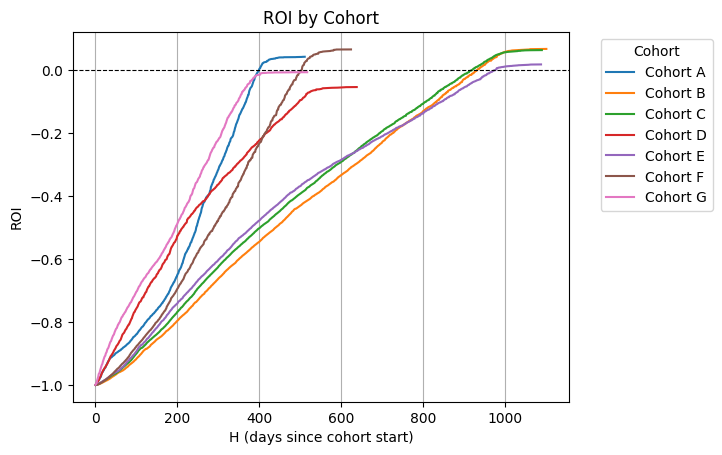

In [10]:
from src.plot.roi import plot_roi_curves

_ = plot_roi_curves(roi_curves_df)

Based on this graph, we can see that out of the 7 cohorts analyzed, 5 are profitable (A, B, C, E, F). Two of them became profitable after about 400–500 days, while the other 3 did so after approximately 1000 days.

Given this observation, it is advisable to consider a horizon H of 1000–1200 days to ensure we capture the profitability of all cohorts.

All cohorts exhibit a strictly increasing, monotonic behavior, with a plateau near the end of the data records. The derivative remains almost constant throughout most observations, but varies abruptly at the beginning of the plateau.

## Cohort Descriptive Analysis
To further understand the characteristics of each cohort, we can perform a descriptive analysis. This involves examining various attributes of the loans and borrowers within each cohort, such as loan amounts, interest rates, and repayment behaviors.

Starting with the proportion of loans in different statuses at the end of the observation period:

In [11]:
# Checking loans last status
loans_last_status = loans_and_cohort.sort_values('updated_at').drop_duplicates(subset=['loan_id'], keep='last')
amount_loans_last_status = loans_last_status['status'].value_counts(normalize=True) * 100
amount_loans_last_status 

status
repaid             88.403518
debt_collection     6.018652
debt_repaid         5.577830
Name: proportion, dtype: float64

**Loan amounts statistics by cohort:**

In [12]:
# Display basic statistics of loan amounts by cohort
loan_stats = loans_last_status.groupby('batch_letter')['loan_amount'].describe()

# puts "Loan amount statistics by cohort:"
display(loan_stats)

,count,mean,std,min,25%,50%,75%,max
batch_letter,,,,,,,,
A,3182.0,247.184670,425.743669,8.0,50.0,50.0,250.0,8430.0
B,5970.0,3725.651616,4246.883997,10.0,1500.0,2500.0,4200.0,53230.0
C,8224.0,3679.260525,3474.860518,13.0,1600.0,2500.0,4500.0,41600.0
D,4967.0,520.059444,383.344239,5.0,500.0,500.0,500.0,10270.0
E,4432.0,3144.803430,2859.133493,20.0,1500.0,2250.0,3700.0,28540.0
F,3621.0,2289.768989,3767.503127,10.0,500.0,1200.0,2420.0,64900.0
G,14747.0,247.168753,652.989170,10.0,50.0,50.0,150.0,15450.0


Distribution of loan amounts by cohort:

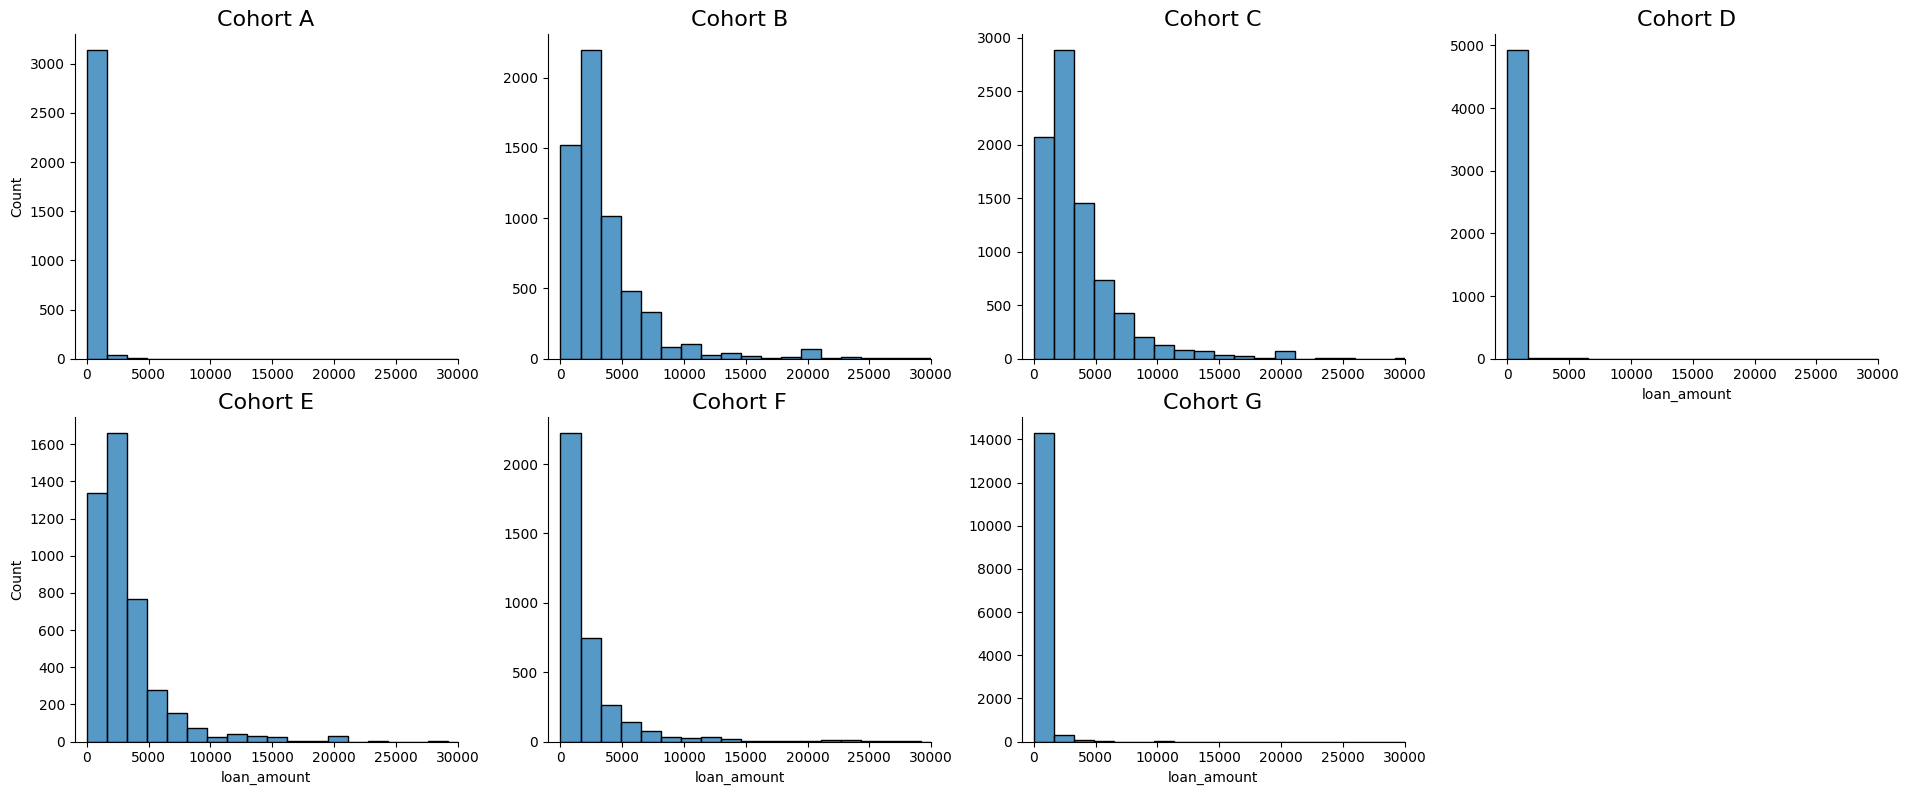

In [13]:
import seaborn as sns

graph = sns.displot(
    data=loans_last_status.sort_values('batch_letter'),
    x="loan_amount",
    col="batch_letter",
    kind="hist",
    col_wrap=4,
    height=4,
    aspect=1.2,
    bins=40,
    facet_kws={"sharex": False, "sharey": False, "xlim": (-1e3, 30e3)},
)

graph.set_titles("Cohort {col_name}", size=16)

All the distributions are right-skewed, with most loans being of smaller amounts and a few loans being of significantly larger amounts. Cohorts B, C, and E have a wider range of loan amounts, while cohorts A, D, F, and G have a more concentrated distribution of smaller loans.

**Annual interest rate distribution by cohort:**

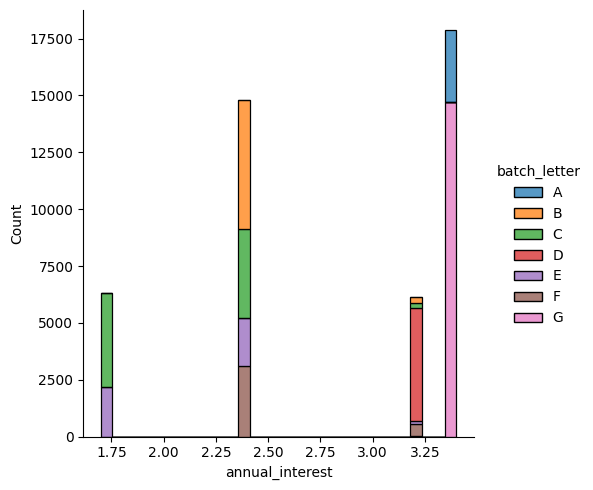

In [14]:
import seaborn as sns

graph = sns.displot(
    data=loans_last_status.sort_values('batch_letter'),
    x="annual_interest",
    hue="batch_letter",
    multiple="stack",
    kind="hist",
)
graph.set_titles("Cohort {col_name}", size=16)

The interest rates are discrete distributed. Batches B, C, E, and F have lower rates (1.75-2.00 %), while batches A, D, and G have higher rates (3.25-3.50 %). This could indicate different risk profiles or loan products offered to different cohorts.

## Correlation of results
**Answering to the question:** 

"Do loans within the same cohort being predominantly repaid increase the chance that a particular loan will be repaid?"

### Modeling loan repayment probability as a function of cohort repayment rate

We can model the probability of loan repayment as a function of the cohort repayment rate using logistic regression. The cohort repayment rate serves as a predictor variable, while the individual loan repayment status (repaid or not) is the response variable.

Let Y be a binary variable indicating whether a loan is repaid (1) or not (0).

Let X be the cohort repayment rate, defined as the proportion of loans in the cohort that have been repaid.

Our model can be expressed as:
$$
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X)}}
$$



In [ ]:
loans_to_consider = loans_last_status[loans_last_status.status.isin(["repaid", "debt_repaid", "debt_collection"])].copy()

# Computing Y variable (loan payed or not)
loans_to_consider.loc[:,"payed"] = loans_to_consider["status"].apply(lambda x: 0 if x == "debt_collection" else 1)

# Computing X (batch repayment rate)
loans_to_consider.loc[:, "batch_repayment_rate"] = loans_to_consider.groupby("batch_letter")["payed"].transform("mean")

display(loans_to_consider.head())

,loan_id,user_id,created_at,updated_at,annual_interest,loan_amount,status,batch,allowlisted_date,batch_letter,cohort_start,created_at_h_days,updated_at_h_days,payed,batch_repayment_rate
23592,9676f6ebe1e53c8d86526dce7e35d53cb3caf1499f631b...,c6b2d1c2b5b0f1d94b32d34bfa2570b5fd8c4bbb3d50c5...,2022-09-15,2022-10-10 12:42:27.332963,1.7,5000.0,repaid,22bda9c4992b30b6b347e22c27f9e59fb9ce99f1072389...,2022-09-09,C,2022-09-09,6,31,1,0.947228
9388,49a53fec91c7b2de68f7de61bd7d6af85a1483f34639f6...,c92401feb20cbd78ab485299541ab1e94c66cb718fd258...,2022-09-16,2022-10-10 12:42:27.332963,1.7,1000.0,repaid,5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f...,2022-09-09,E,2022-09-09,7,31,1,0.916968
61437,b1b6e2a811a11fa4ee98419ebc7248a5b941c0a15b31ba...,fa37f507dd6cb9ad3a0cd99515d46728a63b2c056c0d75...,2022-09-10,2022-10-10 12:42:27.332963,1.7,1000.0,repaid,5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f...,2022-09-09,E,2022-09-09,1,31,1,0.916968
55148,822a4ee7f40bab1d5123540e204eaad5111d079d3fc0cf...,0824272bfdcdb05aa0b732a16c521ab9817ffc91e02e40...,2022-09-11,2022-10-10 12:42:27.332963,1.7,1500.0,repaid,22bda9c4992b30b6b347e22c27f9e59fb9ce99f1072389...,2022-09-09,C,2022-09-09,2,31,1,0.947228
23589,57c4f3a15d0ee5d558c708e77d14ab4012f85a05289184...,c6b2d1c2b5b0f1d94b32d34bfa2570b5fd8c4bbb3d50c5...,2022-09-11,2022-10-10 12:42:27.332963,1.7,1000.0,repaid,22bda9c4992b30b6b347e22c27f9e59fb9ce99f1072389...,2022-09-09,C,2022-09-09,2,31,1,0.947228


In [ ]:
# Fitting the model
from statsmodels.api import Logit
from statsmodels.tools import add_constant

X = loans_to_consider[["batch_repayment_rate"]]
y = loans_to_consider["payed"]
X = add_constant(X)

model = Logit(y, X).fit()

display(model.summary())

Optimization terminated successfully.
         Current function value: 0.211013
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  payed   No. Observations:                45143
Model:                          Logit   Df Residuals:                    45141
Method:                           MLE   Df Model:                            1
Date:                qua, 24 set 2025   Pseudo R-squ.:                 0.07239
Time:                        12:59:42   Log-Likelihood:                -9525.8
converged:                       True   LL-Null:                       -10269.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -8.2710      0.263    -31.399      0.000      -8.787      -7.755
batch_repayment_rate    11.9344      0.290     41.087      0.000      11.365      12.504
========================================================================================
"""

The results show a weak fit of the model, with a pseudo R-squared of 0.07.

The coefficient for batch_repayment_rate is positive and significant, indicating that higher batch repayment rates are associated with a higher likelihood of individual loan repayment, however, this just explains a small part of the variability in loan repayment outcomes.

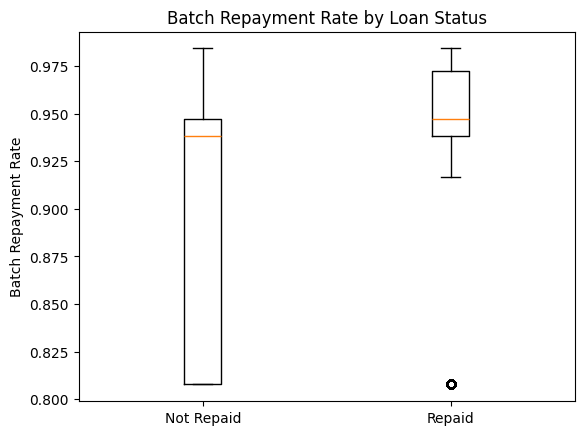

In [ ]:
from matplotlib import pyplot as plt

plt.boxplot([loans_to_consider["batch_repayment_rate"][loans_to_consider["payed"] == 0],
              loans_to_consider["batch_repayment_rate"][loans_to_consider["payed"] == 1]],
             tick_labels=["Not Repaid", "Repaid"])
plt.title("Batch Repayment Rate by Loan Status")
plt.ylabel("Batch Repayment Rate")
plt.show()

This boxplot reinforces what was predicted by the logistic regression model. The medians between the two groups are similar, however, the interquartile range between Q1 and median for the "Not Repaid" group is much larger than that of the "Repaid" group. This indicates that loans that were not repaid tend to belong to cohorts with lower repayment rates, while loans that were repaid are more likely to be part of cohorts with higher repayment rates.

## Sensitivity to large loans

"How much do top exposures move the ROI curve?"

To answer this question, we can perform a sensitivity analysis by excluding the top 5% of loans by amount and recalculating the ROI curves for each cohort.

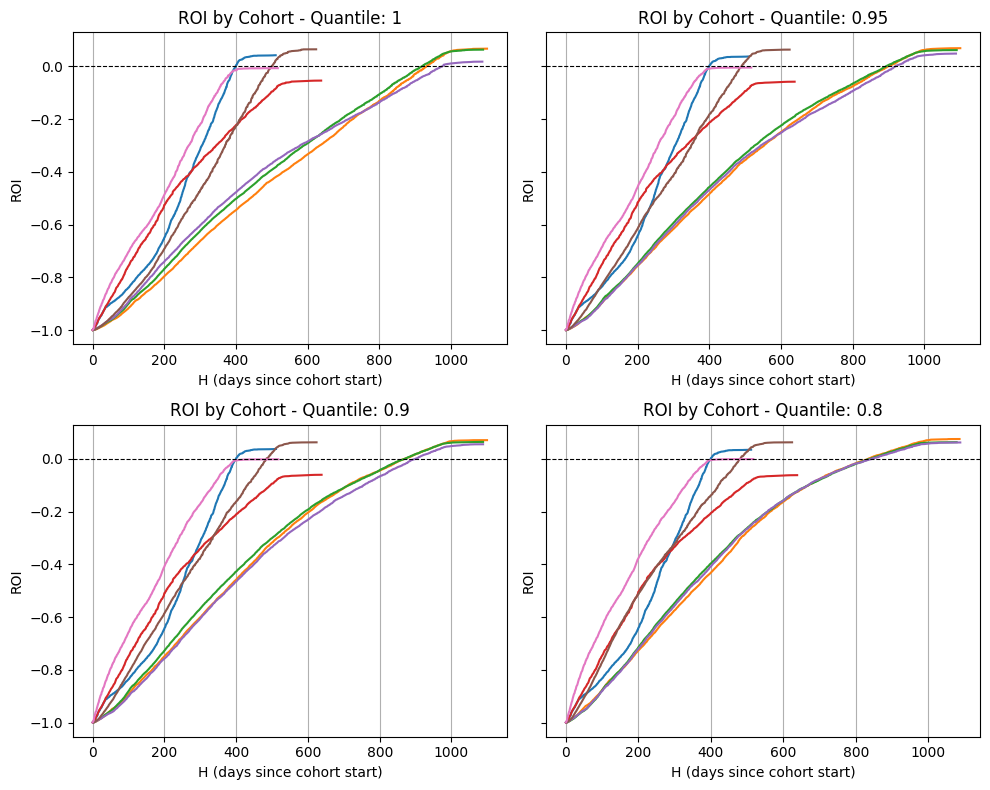

In [ ]:
from src.plot.roi import plot_roi_curves

quantiles = [1, 0.95, 0.9, 0.8]
roi_curves = {}

for q in quantiles:
    threshold = loans_last_status['loan_amount'].quantile(q)
    no_top_loans = loans_last_status[loans_last_status['loan_amount'] < threshold]
    
    cohort_principal_no_top_loans = compute_cohort_principal(no_top_loans)
    
    roi_curve_no_top_loans = compute_roi_curves(
        repayments_and_loans[repayments_and_loans['loan_id'].isin(no_top_loans['loan_id'])],
        cohort_principal_no_top_loans
    )
    
    roi_curves[q] = roi_curve_no_top_loans

# Plotting the ROI curves for each quantile
fig, axs = plt.subplots(2, len(quantiles)//2, figsize=(10, 8), sharey=True)
for ax, (q, roi_curve) in zip(axs.flatten(), roi_curves.items()):
    plot_roi_curves(roi_curve, ax=ax, extra_title=f'Quantile: {q}', show_legend=False)

plt.tight_layout()
plt.show()

It's not possible to see a significant difference in the ROI curves after excluding the top 5%-20% of loans by amount.

## Collection sensitivity analysis

 How would changes in billing amounts affect the curve?

 Let's start by excluding all collection repayments and recalculating the ROI curves.

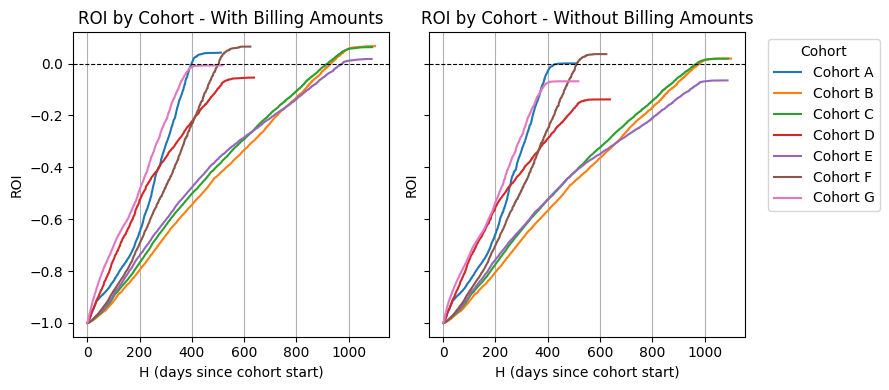

In [ ]:
repayments_and_loans_without_billing = repayments_and_loans.copy()
repayments_and_loans_without_billing["repayment_total"] = repayments_and_loans_without_billing["repayment_amount"]

roi_curves_df_no_billing = compute_roi_curves(
    repayments_and_loans_without_billing, cohort_principal
)
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

data_to_plot = [roi_curves_df, roi_curves_df_no_billing]
for i, ax in enumerate(ax.flatten()):   
    _ = plot_roi_curves(
        data_to_plot[i],
        ax=ax,
        extra_title=["With Billing Amounts", "Without Billing Amounts"][i],
        show_legend=(i==len(data_to_plot)-1),
    )
plt.tight_layout()
plt.show()

The billing amounts have a key impact on the ROI curves. It enables the profitability of Cohort A and E, and reduces the loss of cohorts G and D. In an overall, the impact is significant in increasing the ROI of all cohorts.

In [ ]:
repayments_and_loans

,date,loan_id,repayment_amount,billings_amount,batch_letter,allowlisted_date,loan_amount,cohort_start,created_at,created_at_h_days,h_days,repayment_total
0,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.00,0.15,B,2022-08-29,9750.0,2022-08-29,2022-08-30,1.0,106.0,0.15
1,2022-12-13,059f1d15ef6b5990280bb37efb4325b71b1d3b68c9c847...,0.00,71.88,B,2022-08-29,2750.0,2022-08-29,2022-08-30,1.0,106.0,71.88
2,2022-12-13,bfde49d91ce96adc8b2f04a25850c929f6688d81e26b06...,0.00,1312.95,B,2022-08-29,9750.0,2022-08-29,2022-08-30,1.0,106.0,1312.95
3,2022-12-13,c1636359078ef9fc7a37aacb4afba4610d2492c1769d24...,0.00,344.18,B,2022-08-29,4000.0,2022-08-29,2022-08-30,1.0,106.0,344.18
4,2022-12-13,6cc14f085ec7834225629bc7e619d1d1bc03b36b1f5349...,0.00,98.07,B,2022-08-29,3250.0,2022-08-29,2022-08-30,1.0,106.0,98.07
...,...,...,...,...,...,...,...,...,...,...,...,...
606641,2025-07-23,0fc1987eea1cd5f8d7e3701a4dbf14c64ed873989be65a...,100.28,0.00,C,2022-09-09,16870.0,2022-09-09,2025-04-24,958.0,1048.0,100.28
606642,2025-07-23,4c8640eb3165b8ec4658f8438319014321c2ddeac591a8...,544.87,0.00,B,2022-08-29,26100.0,2022-08-29,2025-04-25,970.0,1059.0,544.87
606643,2025-07-23,a57431a8700495819c06895d4d1fbd129cf72f0a6c532a...,15.00,0.00,E,2022-09-09,3600.0,2022-09-09,2025-04-24,958.0,1048.0,15.00
606644,2025-07-24,4c8640eb3165b8ec4658f8438319014321c2ddeac591a8...,144.16,0.00,B,2022-08-29,26100.0,2022-08-29,2025-04-25,970.0,1060.0,144.16


In [ ]:
batch_sums = repayments_and_loans.groupby("batch_letter")[["repayment_amount", "billings_amount"]].sum()
batch_sums["total_repaid"] = batch_sums["repayment_amount"] + batch_sums["billings_amount"] 
batch_sums["normal_ratio"] = batch_sums["repayment_amount"] / batch_sums["total_repaid"] * 100
batch_sums["collections_ratio"] = batch_sums["billings_amount"] / batch_sums["total_repaid"] * 100
batch_sums["ROI"] = batch_sums["total_repaid"] / loans_last_status.groupby("batch_letter")["loan_amount"].sum() - 1
display(batch_sums[["normal_ratio", "collections_ratio", "ROI"]])

,normal_ratio,collections_ratio,ROI
batch_letter,,,
A,96.010292,3.989708,0.042004
B,95.519697,4.480303,0.066907
C,95.836314,4.163686,0.063170
D,91.096928,8.903072,-0.054164
E,91.865268,8.134732,0.017667
F,97.273751,2.726249,0.065285
G,93.814914,6.185086,-0.007087


Collections represent a small portion of the total repayments across all batches. Most batches have a normal repayment ratio above 90%, indicating that the majority of repayments come from regular payments rather than collections.

Lets look the correlation between collections repayment ratio and ROI.

                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.693
No. Observations:                   7   F-statistic:                     14.53
Covariance Type:            nonrobust   Prob (F-statistic):             0.0125
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1217      0.026      4.602      0.006       0.054       0.190
collections_ratio    -0.0171      0.004     -3.811      0.012      -0.029      -0.006

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


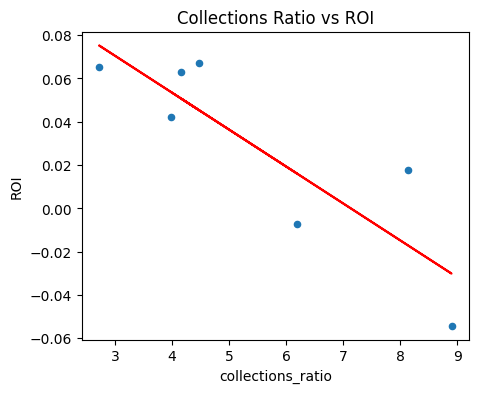

In [ ]:

import statsmodels.api as sm

# Computing a linear regression model between collections ratio and ROI
X = sm.add_constant(batch_sums["collections_ratio"])
y = batch_sums["ROI"]
model = sm.OLS(y, X).fit()
print(model.summary(slim=True))

# Create the scatter plot
ax = batch_sums.plot(
    kind="scatter", x="collections_ratio", y="ROI", title="Collections Ratio vs ROI", figsize=(5,4)
)
ax.plot(batch_sums["collections_ratio"], model.predict(X), color='red')

The R-squared of 0.747 indicates that the collections ratio explains a substantial part of the variance in ROI. The negative coefficient (-0.0171) for the collections ratio is statistically significant (p = 0.012 < 0.05), despite having few observations, suggesting that higher collections ratios are associated with lower ROI.

This shows an expected correlation: cohorts with bad payers tends to have lower ROI and rely more on collections to recover their losses.

And obviously, the opposite is also true: higher normal payment ratios are associated with higher ROI.

## First Loan Tolerance

How much initial default rate could this cohort tolerate and still reach non-negative ROI by horizon $H$?

Stating some definitions:

- **initial default loans:** the loans in the cohort that are expected to default at the beginning of the investment horizon.
- **initial default rate:** = (Principal amount of initialdefaulted loans) / (Total principal amount of cohort)

To answer this question, we can simulate different initial default rates for the cohort and calculate the ROI at horizon $H$ for each scenario. The goal is to find the maximum initial default rate that still results in a non-negative ROI.

To get a better understanding about how to perform this simulation, let's look at the distribution of loan principal amounts across cohorts.

### Stratified loan selection for initial default simulation

Since the loan amounts are right-skewed, randomly selecting loans to default could lead to biased results. To mitigate this, we can use **stratified sampling** based on loan amount percentiles.

This approach ensures that we select defaulted loans from different segments of the loan amount distribution, providing a more representative simulation of initial defaults.

The code to perform is quite complex, so I moved it to a separate file: `initial_default_rate_tolerance.py`.
The basic idea is to divide the loans into `3` stratum based on their amount percentiles, and then select defaulted loans from each stratum proportionally to its size.

In some cases, due the highly concentrated distribution of loan amounts, it may not be possible to split in 3 stratum. In this case, we will reduce the number of stratum until it is possible to split the loans (obviously, 1 stratum is always possible).

The number of loans to default in each stratum is determined by the target initial default rate. 

**Example:** If we have a target initial default rate of 5%, we would select stratified random loans until the total principal of the selected loans reaches 5% (within a small tolerance) of the total principal of the cohort.

Let's look at the results of the stratified sampling for cohort A.

In [ ]:
from src.stratified_selection import stratified_loan_selection

cohort_a_loans = loans_last_status[loans_last_status["batch_letter"] == "A"]

stratified_a_selection = stratified_loan_selection(
    loans_df=cohort_a_loans, target_default_rate=0.05, random_state=42
)
target_default_rate = (
    stratified_a_selection["loan_amount"].sum() / cohort_a_loans["loan_amount"].sum()
)
print("Default rate for Cohort A:", target_default_rate)

stratified_a_selection[["loan_id", "loan_amount", "size_stratum", "batch_letter"]].head(10)


Selected 84 loans from Small stratum
Selected 21 loans from Medium stratum
Selected 45 loans from Large stratum
Default rate for Cohort A: 0.04789320621075335


,loan_id,loan_amount,size_stratum,batch_letter
126424,86d4732dc2a89c77671497e94e46741f6890c430efd729...,50.0,Small,A
144881,0fb58d3075ec004095b0e52175091ba1db93f838516287...,150.0,Medium,A
130229,4069f1502c161d18caa641b8825b2bbe794be2860e4554...,100.0,Medium,A
144885,bffc30c961904d96cd17bcea0fafc94e3737aa61139082...,50.0,Small,A
153976,011d98dae7267f2ce9f08393427f28a30acbe57708e26c...,50.0,Small,A
153919,6b35a9b305d8ff64724bdc41248ece0779e496f9548e86...,150.0,Medium,A
126441,d253a222212a53fb1c174dc8caaeb74294653f2625164f...,50.0,Small,A
39761,ed154b46f32f964b4d75024847b16c2483cfbd96a57562...,50.0,Small,A
96209,8b817501ebb512dfe75d9fe4eb40b3a2ec75dbef02812d...,400.0,Large,A
132377,72054b54bab113d9ceb266ccea6c88c7731830093e2e82...,40.0,Small,A


If we change a **different** ``random_state``, we should get a slightly different selection, however, with the same default rate

In [ ]:
stratified_a_selection = stratified_loan_selection(
    loans_df=cohort_a_loans, target_default_rate=0.05, random_state=1
)
target_default_rate = (
    stratified_a_selection["loan_amount"].sum() / cohort_a_loans["loan_amount"].sum()
)
print("Default rate for Cohort A (different random state):", target_default_rate)

Selected 83 loans from Small stratum
Selected 20 loans from Medium stratum
Selected 40 loans from Large stratum
Default rate for Cohort A (different random state): 0.04791354842735469


### Initial default rate tolerance simulation

With the stratified loan selection function in place, we can now define a simple function to simulate different initial default rates and calculate the ROI at horizon $H$ for each scenario.

The idea is just to iterate over a range of default rates, select the corresponding loans to default using the stratified selection function, and then calculate the ROI at horizon $H$ excluding the repayments from the defaulted loans.


In [ ]:
import numpy as np

# NOTE: I choose leave this function in the notebook for clarity

def simulate_default_tolerance(
    cohort_letter, default_rates=None, random_state=42, verbose=False
) -> tuple[pd.DataFrame, float]:
    """
    Simulate ROI at horizon H for different initial default rates using stratified sampling.

    Args:
        cohort_letter: The cohort to analyze
        default_rates: List of default rates to test
        random_state: Random seed for reproducibility
        verbose: Whether to print detailed output

    Returns:
        tuple: (DataFrame with default rates and ROI values, maximum tolerable default rate)
    """
    if default_rates is None:
        default_rates = np.linspace(0.01, 0.1, 10)  # 1% to 10% in 1% increments

    # Get cohort data
    cohort_loans = loans_last_status[
        loans_last_status["batch_letter"] == cohort_letter
    ].copy()
    cohort_repayments = repayments_and_loans[
        repayments_and_loans["loan_id"].isin(cohort_loans["loan_id"])
    ].copy()

    results = {"default_rates": [], "roi_values": []}

    for target_default_rate in default_rates:
        # Select loans for default using stratified sampling
        defaulted_loans_selection = stratified_loan_selection(
            cohort_loans,
            target_default_rate,
            random_state=random_state,
            verbose=verbose,
        )
            
        # Simulate scenario: remove repayments for defaulted loans
        scenario_repayments = cohort_repayments[
            ~cohort_repayments["loan_id"].isin(defaulted_loans_selection["loan_id"])
        ].copy()

        # Calculate total repayments at horizon H
        total_repayments = scenario_repayments["repayment_total"].sum()

        # Calculate ROI
        roi = (total_repayments / cohort_loans["loan_amount"].sum()) - 1

        true_default_rate = (
            defaulted_loans_selection["loan_amount"].sum()
            / cohort_loans["loan_amount"].sum()
        )

        results["default_rates"].append(true_default_rate)
        results["roi_values"].append(roi)

        if verbose:
            print(
                f"Default rate: {target_default_rate:.1%}, ROI: {roi:.3f}, Defaulted loans: {len(defaulted_loans_selection)}"
            )

    df_results = pd.DataFrame(results)
    positive_roi_results = df_results[df_results["roi_values"] > 0]
    if len(positive_roi_results) > 0:
        max_tolerance_rate = positive_roi_results["default_rates"].max()
    else:
        max_tolerance_rate = 0.0
    return df_results, max_tolerance_rate


# Test the stratified sampling approach for Cohort B (profitable cohort)
cohort_to_test = "A"
tolerance_results, max_tolerance_rate = simulate_default_tolerance(cohort_to_test, verbose=False)
pd.DataFrame(tolerance_results)

,default_rates,roi_values
0,0.009872,0.031431
1,0.019306,0.021456
2,0.029210,0.011060
3,0.039286,0.000926
4,0.047893,-0.008064
5,0.057918,-0.018817
6,0.067040,-0.028729
7,0.076430,-0.038511
8,0.086283,-0.048973
9,0.095385,-0.059009


Now, let's compute the default tolerance results for all cohorts and plot the results.

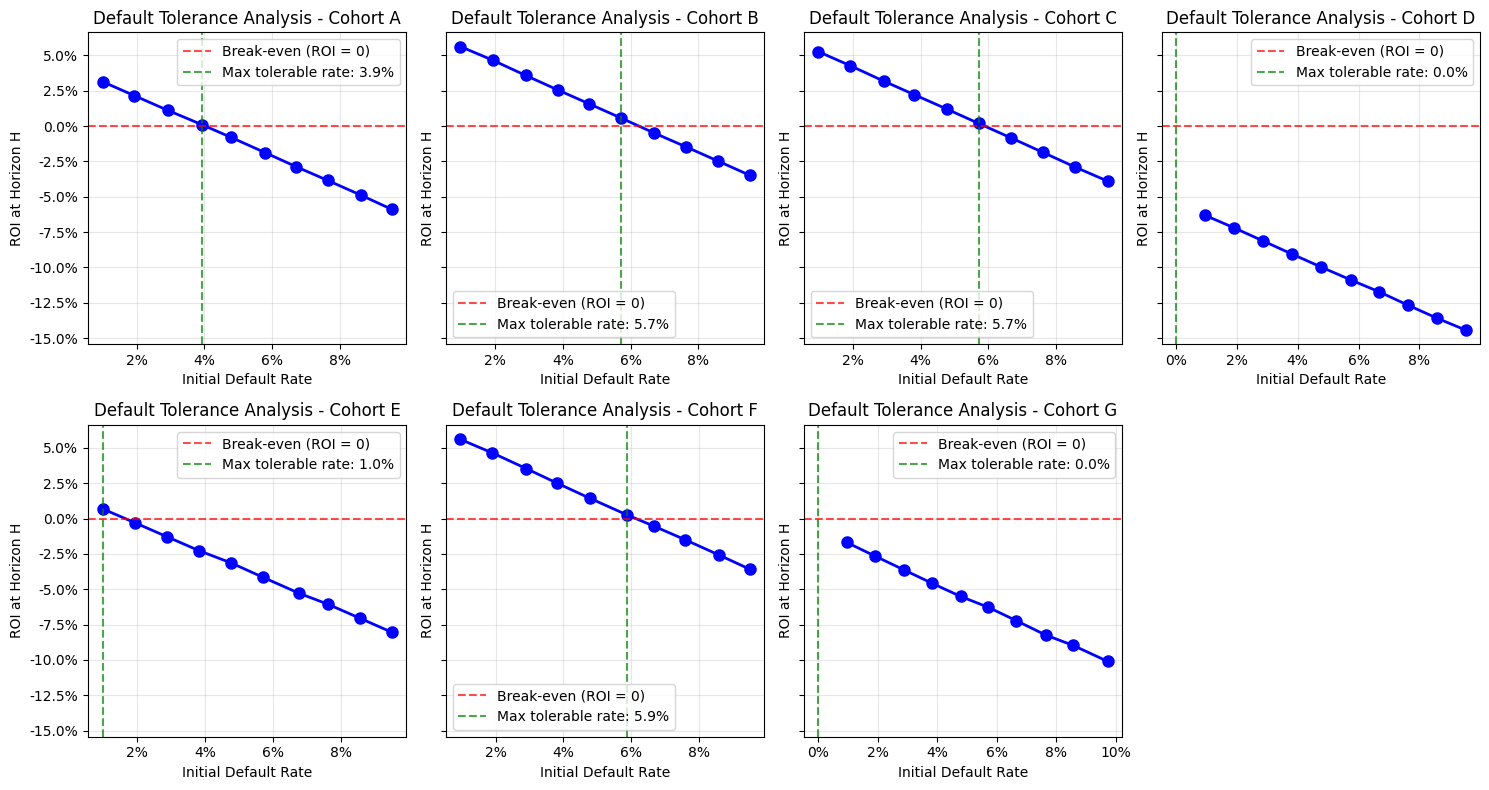

In [ ]:
from src.plot.initial_default_rate_tolerance import (
    initial_default_tolerance_simulation_plot,
)

all_cohorts_letters = loans_last_status["batch_letter"].unique()
all_cohorts_letters.sort()

fig, axes = plt.subplots(2, 4, figsize=(15, 8), sharey=True)
flattened_axes = axes.flatten()

for i, cohort_letter in enumerate(all_cohorts_letters):
    tolerance_results, max_tolerance_rate = simulate_default_tolerance(
        cohort_letter, verbose=False
    )
    _ = initial_default_tolerance_simulation_plot(
        tolerance_results, max_tolerance_rate, cohort_letter, ax=flattened_axes[i]
    )

flattened_axes[-1].remove()
plt.tight_layout()
plt.show()

The cohorts D and G are not profitable even with no initial defaults, so their maximum tolerance rates are 0%. Cohort E has a ROI very close to 0%, so its maximum tolerance rate is also very low.

The cohorts B,C and D are the most robust to initial defaults, being close to 6%. Cohort A is in an intermediate position, tolerating around 4% of initial defaults.

An important observation that can be made is that the tolerance rate seems to vary linearly with the ROI at horizon H.

### Repeating the simulation with different random seeds

To ensure that our approach is not too sensitive to the random selection of defaulted loans, we can repeat the simulation with a different random seeds.

Lets consider that each seed represents a experiment.

We can then aggregate the results across all experiments to obtain a more robust estimate of the maximum tolerance rate for each cohort.

In [ ]:
# Define random seeds and cohorts
random_seeds = [1, 2, 3, 4, 5]
all_cohorts_letters = loans_last_status["batch_letter"].unique()
all_cohorts_letters.sort()

# Dictionary to store results for each cohort
cohort_tolerance_results = {}

# Compute max tolerance rate for each cohort across different random seeds
for cohort_letter in all_cohorts_letters:
    max_tolerance_rates = []
    
    for seed in random_seeds:
        tolerance_results, max_tolerance_rate = simulate_default_tolerance(
            cohort_letter, random_state=seed, verbose=False
        )    
        max_tolerance_rates.append(max_tolerance_rate)
    
    cohort_tolerance_results[cohort_letter] = max_tolerance_rates

# Create summary table with mean and std
summary_data = []
for cohort_letter in all_cohorts_letters:
    rates = cohort_tolerance_results[cohort_letter]
    summary_data.append({
        'cohort': cohort_letter,
        'mean_tolerance_rate': np.mean(rates),
        'std_tolerance_rate': np.std(rates)
    })

tolerance_summary_df = pd.DataFrame(summary_data)
display(tolerance_summary_df)

,cohort,mean_tolerance_rate,std_tolerance_rate
0,A,0.036718,0.004008
1,B,0.057251,0.000117
2,C,0.057258,0.000158
3,D,0.000000,0.000000
4,E,0.009788,0.000045
5,F,0.057450,0.000560
6,G,0.000000,0.000000


The table above shows that the results are quite stable across different experiments, with only minor variations in the maximum tolerance rates. They are also the very close to the results displayed in the previous graph.

But one question raises: **what variable could explain the differences in tolerance rates across cohorts?**

My first guess would be the **original ROI at horizon H**.

### Comparing initial default tolerance rate with ROI at horizon H

For this comparison, I am considering just cohorts with positive ROI, since negative ROI cohorts have a tolerance rate of 0% by definition.

                             OLS Regression Results                            
Dep. Variable:     mean_tolerance_rate   R-squared:                       0.993
Model:                             OLS   Adj. R-squared:                  0.991
No. Observations:                    5   F-statistic:                     445.3
Covariance Type:             nonrobust   Prob (F-statistic):           0.000233
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0065      0.003     -2.577      0.082      -0.015       0.002
final_roi      0.9850      0.047     21.101      0.000       0.836       1.134

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


C:\Users\vitor\AppData\Local\Temp\ipykernel_29832\1141145465.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_line = model_trend.params[0] + model_trend.params[1] * x_line
c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


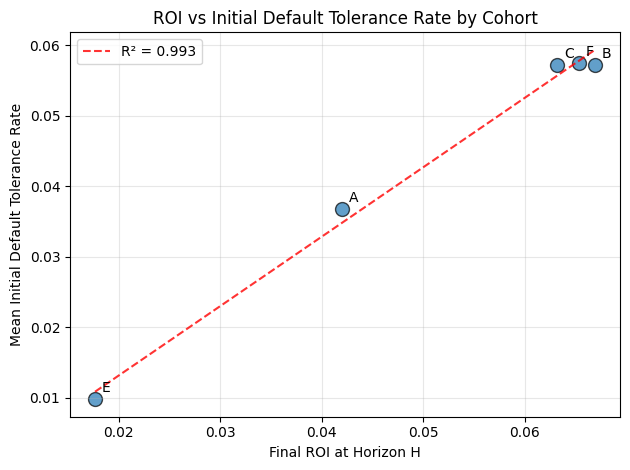

In [ ]:
import statsmodels.api as sm

# Extract ROI values from batch_sums and merge with tolerance data
roi_final = batch_sums["ROI"]

# Create a combined dataframe for analysis
comparison_df = tolerance_summary_df.copy()
comparison_df["final_roi"] = comparison_df["cohort"].map(roi_final)
comparison_df = comparison_df[comparison_df["final_roi"] > 0]

ax = comparison_df.plot.scatter(x="final_roi", y="mean_tolerance_rate", s=100, alpha=0.7, edgecolors='black')

# Add cohort labels to points
for i, row in comparison_df.iterrows():
    ax.annotate(row["cohort"], 
                (row["final_roi"], row["mean_tolerance_rate"]),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

# Add fitted line
X_trend = sm.add_constant(comparison_df["final_roi"])
model_trend = sm.OLS(comparison_df["mean_tolerance_rate"], X_trend).fit()
x_line = np.linspace(comparison_df["final_roi"].min(), comparison_df["final_roi"].max(), 100)
y_line = model_trend.params[0] + model_trend.params[1] * x_line
ax.plot(x_line, y_line, 'r--', alpha=0.8, label=f'R² = {model_trend.rsquared:.3f}')

ax.set_xlabel("Final ROI at Horizon H")
ax.set_ylabel("Mean Initial Default Tolerance Rate")
ax.set_title("ROI vs Initial Default Tolerance Rate by Cohort")
ax.legend()
ax.grid(True, alpha=0.3)

print(model_trend.summary(slim=True))
plt.tight_layout()
plt.show()

The fit of the linear regression model is very good, with an R-squared of 0.97, indicating that the ROI at horizon H explains the maximum tolerance rate.

## Expected Loss Estimation

The expected loss is a fundamental concept in credit risk management that quantifies the potential financial loss from defaults. It can be calculated as:

$$
EL = PD \times LGD \times EAD
$$

Where:
- **PD** (Probability of Default): The likelihood that a borrower will default within a specific time horizon
- **LGD** (Loss Given Default): The percentage of exposure lost if default occurs (1 - Recovery Rate)
- **EAD** (Exposure at Default): The total amount at risk when default occurs

In our cohort analysis, we can compute these components over different time horizons to understand how expected losses evolve and vary across cohorts.

Since we dont have PD, LGD and EAD directly, we will estimate them based on the available data.

PD(t) = (Number of loans defaulted by time t) / (Total number of loans in cohort)

LGD(t) = (Total exposure - Total recovery) / Total exposure

EAD(t) = Cohort principal amount - Repayments by time t

In [ ]:
def compute_expected_loss(
    loans_and_cohort: pd.DataFrame,
    repayments_and_loans: pd.DataFrame,
    batch_letter: str,
    time_cut: int,
) -> tuple[float, float, float, float]:
    """
    Compute the expected loss for a given cohort at a specific time horizon.

    Args:
        loans_and_cohort: DataFrame containing loan and cohort information.
        repayments_and_loans: DataFrame containing repayment and loan information.
        batch_letter: The cohort batch letter to analyze.
        time_cut: The time horizon in days to consider.

    Returns:
        A tuple containing the probability of default, loss given default, and the expected loss.
    """

    loans_status_at_t = (
        loans_and_cohort[
            (loans_and_cohort["batch_letter"] == batch_letter)
            & (loans_and_cohort["updated_at_h_days"] <= time_cut)
        ]
        .sort_values("updated_at_h_days")
        .drop_duplicates(subset=["loan_id"], keep="last")
    )

    unpaid_loans_at_t = loans_status_at_t[
        loans_status_at_t["status"] == "debt_collection"
    ]
    if unpaid_loans_at_t.empty:
        return 0.0, 0.0, 0.0, 0.0

    probability_of_default = len(unpaid_loans_at_t) / len(loans_last_status)

    unpaid_loans_principal = unpaid_loans_at_t["loan_amount"].sum()

    repayments_and_loans_at_t = repayments_and_loans[
        (repayments_and_loans["batch_letter"] == batch_letter)
        & (repayments_and_loans["h_days"] <= time_cut)
    ]

    repayments_of_default_loans_at_t = repayments_and_loans_at_t[
        repayments_and_loans_at_t.loan_id.isin(unpaid_loans_at_t.loan_id)
    ][["repayment_total"]].sum()

    loss_given_default = (
        unpaid_loans_principal - repayments_of_default_loans_at_t["repayment_total"]
    ) / unpaid_loans_principal

    amount_in_risk = (
        loans_status_at_t["loan_amount"].sum()
        - repayments_and_loans_at_t["repayment_total"].sum()
    )
    if amount_in_risk < 0:
        amount_in_risk = 0.0

    expected_loss = probability_of_default * loss_given_default * amount_in_risk

    return probability_of_default, loss_given_default, amount_in_risk, expected_loss

In [ ]:
time_range = np.arange(30, 1200, 120)
expected_loss_results = {
    "batch_letter": [],
    "time_cut": [],
    "probability_of_default": [],
    "loss_given_default": [],
    "amount_in_risk": [],
    "expected_loss": [],
}

for batch_letter in all_cohorts_letters:
    for time_cut in time_range:
        probability_of_default, loss_given_default, amount_in_risk, expected_loss = (

            compute_expected_loss(
                loans_and_cohort, repayments_and_loans, batch_letter, int(time_cut)
            )
        )
        expected_loss_results["batch_letter"].append(batch_letter)
        expected_loss_results["time_cut"].append(time_cut)
        expected_loss_results["probability_of_default"].append(probability_of_default)
        expected_loss_results["loss_given_default"].append(loss_given_default)
        expected_loss_results["amount_in_risk"].append(amount_in_risk)
        expected_loss_results["expected_loss"].append(expected_loss)

expected_loss_results = pd.DataFrame(expected_loss_results)

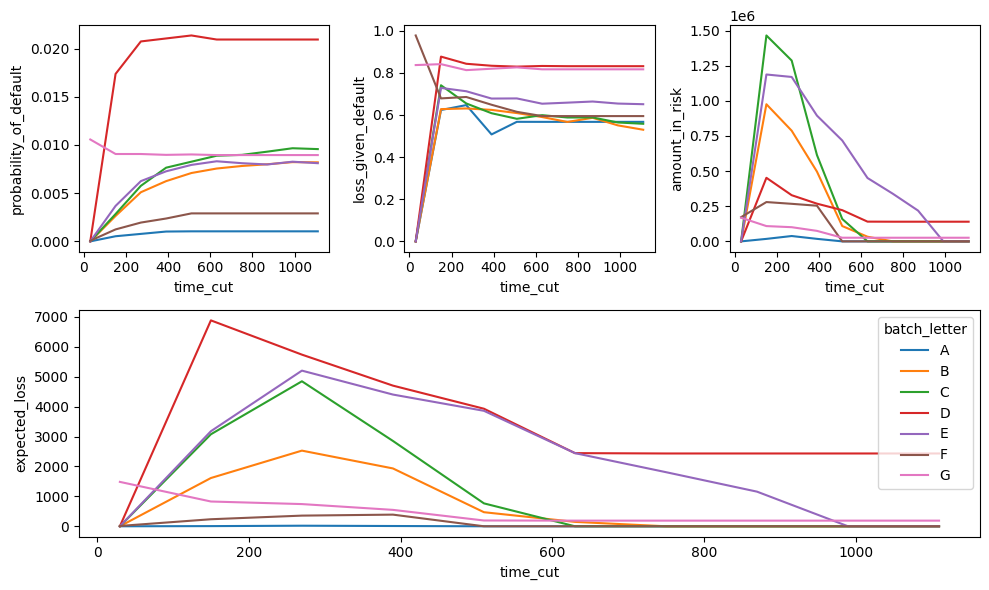

In [ ]:
import seaborn as sns
from matplotlib import gridspec

fig = plt.figure(figsize=(10, 6))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios=[1, 1, 1], height_ratios=[1, 1])
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[0, 2])
ax3 = fig.add_subplot(spec[1, :])

_ = sns.lineplot(data=expected_loss_results, x="time_cut", y="probability_of_default", hue="batch_letter", ax=ax0, legend=False)
_ = sns.lineplot(data=expected_loss_results, x="time_cut", y="loss_given_default", hue="batch_letter", ax=ax1, legend=False)
_ = sns.lineplot(data=expected_loss_results, x="time_cut", y="amount_in_risk", hue="batch_letter", ax=ax2, legend=False)
_ = sns.lineplot(data=expected_loss_results, x="time_cut", y="expected_loss", hue="batch_letter", ax=ax3)
plt.tight_layout()
plt.show()

Remember that cohorts D and G are the only non-profitable groups, but their expected loss curves over time are quite different. 

From the graphs, cohort D shows a very high probability of default (PD), with about 2% of its loans entering debt collection, and a loss given default (LGD) of 80%. Even though its exposure at default (EAD) is relatively small, cohort D has the highest expected loss compared to all other cohorts.

Cohort G, in contrast, has a lower PD (about 1% of loans in debt collection) and a similar LGD of around 80%, with even lower exposure. This results in a much smaller expected loss for cohort G.

Also note that all profitable Cohorts reduced they expected loss to zero after becoming profitable, while the non-profitable cohorts D and G maintained a positive expected loss throughout the observation period.

All expected loss curves exhibit a similar pattern: they start low, increase over time, and then decrease until a plateau. The risk peak for all cohorts occurs between 100 - 300 days, which is earlier than the point where most cohorts become profitable (around 400-500 days). This indicates that the highest risk of loss happens relatively early in the loan lifecycle, before the cohorts reach profitability.

I belive that we can consider a decision $t$ about 300 days, since it is near the peak of expected loss for all cohorts. This timing allows us to capture the period of highest risk before the cohorts become profitable.